Epoch 1/20
122/122 - 4s - loss: 0.2351 - val_loss: 0.1548 - 4s/epoch - 33ms/step
Epoch 2/20
122/122 - 1s - loss: 0.1505 - val_loss: 0.1409 - 955ms/epoch - 8ms/step
Epoch 3/20
122/122 - 1s - loss: 0.1389 - val_loss: 0.1314 - 931ms/epoch - 8ms/step
Epoch 4/20
122/122 - 1s - loss: 0.1284 - val_loss: 0.1276 - 970ms/epoch - 8ms/step
Epoch 5/20
122/122 - 1s - loss: 0.1192 - val_loss: 0.1226 - 956ms/epoch - 8ms/step
Epoch 6/20
122/122 - 1s - loss: 0.1120 - val_loss: 0.1192 - 960ms/epoch - 8ms/step
Epoch 7/20
122/122 - 1s - loss: 0.1033 - val_loss: 0.1166 - 947ms/epoch - 8ms/step
Epoch 8/20
122/122 - 1s - loss: 0.0970 - val_loss: 0.1130 - 951ms/epoch - 8ms/step
Epoch 9/20
122/122 - 1s - loss: 0.0925 - val_loss: 0.1092 - 943ms/epoch - 8ms/step
Epoch 10/20
122/122 - 1s - loss: 0.0876 - val_loss: 0.1054 - 971ms/epoch - 8ms/step
Epoch 11/20
122/122 - 1s - loss: 0.0835 - val_loss: 0.1027 - 940ms/epoch - 8ms/step
Epoch 12/20
122/122 - 1s - loss: 0.0811 - val_loss: 0.1014 - 980ms/epoch - 8ms/step
Epo

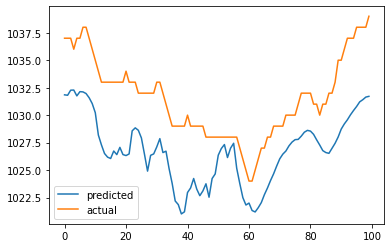

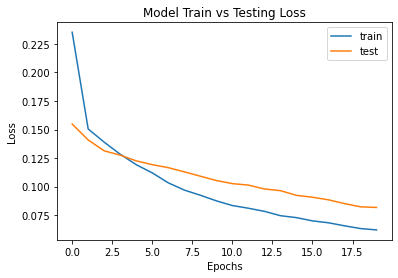

In [104]:
#from numpy import array

from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.core import Dropout
from keras.layers import LSTM

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

#load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values

#integer encode wind direction, as it's the only categorical variable.
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])

#ensure all data are float32 values
values = values.astype('float32')

#normalize input features
# Split before scaling. Apply the scaling separately to both train and test sets. fit_transform and transform resp.
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

#frame as supervised learning
n_hours = 3 
n_features = 8 
reframed = series_to_supervised(scaled, n_hours, 1)
values = reframed.values
n_train_hours = 365*24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

#CHANGES HERE
#split into input and outputs
n_obs = n_hours * n_features
train_X = train[:, :n_obs]
train_y = train[:, -n_features:(-n_features+4)] #+2 because of indexing madness.
test_X = test[:, :n_obs]
test_y = test[:, -n_features:(-n_features+4)]

train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))

#CHANGES HERE
#Need to output two values, not one.
#design network
model = Sequential()
#model.add(LSTM(10, activation='relu', return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(8, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
#model.add(LSTM(10, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.1))
model.add(Dense(4)) #changed from 1 to 2.
model.compile(loss='mae', optimizer='adam')

#fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

#make a prediction
y_hat = model.predict(test_X)

#CHANGES HERE
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
inv_yhat = concatenate((y_hat, test_X[:,-4:]), axis=1) #changed 7 to 6
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0:4] #changed from 0 to 0:2. Should be first 2 columns that contain the predictions

#CHANGES HERE
#invert scaling for actual
test_y = test_y.reshape((len(test_y),4)) #changed 1 to 2
inv_y = concatenate((test_y, test_X[:,-4:]), axis=1) #changed 7 to 6
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0:4] #changed from 0 to 0:2. Should be first 2 columns that contain the predictions.

#CHANGES HERE
#calculate RMSE - CHANGED to output RMSE for each variable.
#rmse_0 = sqrt(mean_squared_error(test_y[:,0], y_hat[:,0])) #RMSE for the first variable (pollution)
# rmse_1 = sqrt(mean_squared_error(test_y[:,0], y_hat[:,0])) #RMSE for the first variable (pollution)
# rmse_2 = sqrt(mean_squared_error(test_y[:,1], y_hat[:,1])) #RMSE for the first variable (pollution)
# rmse_3 = sqrt(mean_squared_error(test_y[:,2], y_hat[:,2])) #RMSE for the first variable (pollution)
# rmse_4 = sqrt(mean_squared_error(test_y[:,3], y_hat[:,3])) #RMSE for the first variable (pollution)

rmse_1 = sqrt(mean_squared_error(inv_y[:,0], inv_yhat[:,0])) #RMSE for the first variable (pollution)
rmse_2 = sqrt(mean_squared_error(inv_y[:,1], inv_yhat[:,1])) #RMSE for the second variable (dew)
rmse_3 = sqrt(mean_squared_error(inv_y[:,2], inv_yhat[:,2])) #RMSE for the second variable (temp)
rmse_4 = sqrt(mean_squared_error(inv_y[:,3], inv_yhat[:,3])) #RMSE for the second variable (press)
print('Test RMSE: ', rmse_1, rmse_2, rmse_3, rmse_4)
model.summary()

pyplot.plot(inv_yhat[0:100,3], label='predicted')
pyplot.plot(inv_y[0:100,3], label='actual')
pyplot.legend()
pyplot.show()

# plot history
pyplot.xlabel('Epochs')
pyplot.ylabel('Loss')
pyplot.title('Model Train vs Testing Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

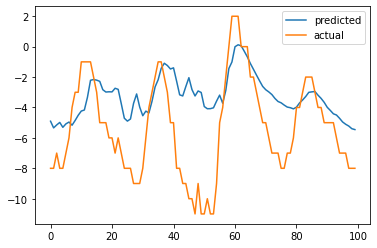

In [82]:
pyplot.plot(inv_yhat[0:100,2], label='predicted')
pyplot.plot(inv_y[0:100,2], label='actual')
pyplot.legend()
pyplot.show()

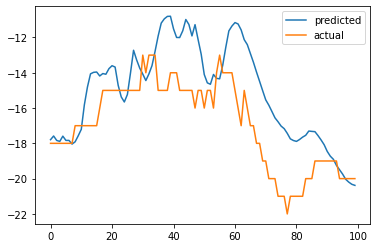

In [83]:
pyplot.plot(inv_yhat[0:100,1], label='predicted')
pyplot.plot(inv_y[0:100,1], label='actual')
pyplot.legend()
pyplot.show()

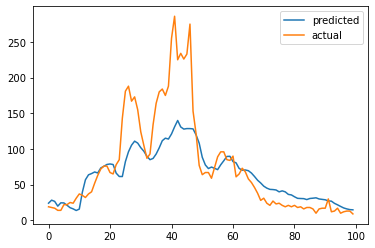

In [84]:
pyplot.plot(inv_yhat[0:100,0], label='predicted')
pyplot.plot(inv_y[0:100,0], label='actual')
pyplot.legend()
pyplot.show()

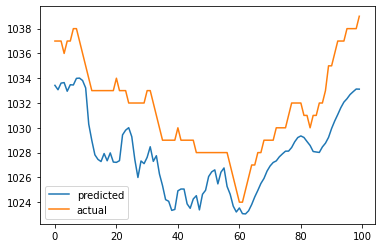

In [85]:
pyplot.plot(inv_yhat[0:100,-1], label='predicted')
pyplot.plot(inv_y[0:100,-1], label='actual')
pyplot.legend()
pyplot.show()

In [108]:
dataset = read_csv('pollution.csv', header=0, index_col=0)
s = dataset.duplicated().sum()
p = dataset.isnull().sum()
p

pollution    0
dew          0
temp         0
press        0
wnd_dir      0
wnd_spd      0
snow         0
rain         0
dtype: int64